# LangGraph ReAct Agent

In [17]:
from typing import List
from typing_extensions import TypedDict
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
import os 
import uuid

In [5]:
load_dotenv()

True

In [9]:
AZURE_OPENAI_API_KEY = os.getenv('AZURE_OPENAI_API_KEY')
os.environ["AZURE_OPENAI_ENDPOINT"] = os.getenv('AZURE_OPENAI_ENDPOINT')
os.environ["AZURE_OPENAI_API_VERSION"] = "2023-06-01-preview"

from langchain_openai import  AzureChatOpenAI

llm = AzureChatOpenAI(
    openai_api_version="2023-06-01-preview",
    azure_deployment=os.getenv('AZURE_OPENAI_DEPLOYMENT'),
    azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
    streaming=True
)

In [24]:
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [ ]:
# embeddings = OpenAIEmbeddings(
#     deployment=os.getenv("AZURE_EMBEDDING_DEPLOYMENT_MODEL")
# )

# Retriever Tool

In [25]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore

urls = [
    "https://blog.relari.ai/choosing-the-right-ai-agent-framework-langgraph-vs-crewai-vs-openai-swarm-56f7931b4249",
    "https://medium.com/cyberark-engineering/building-production-ready-ai-agents-with-langgraph-a-real-life-use-case-7bda34c7f4e4",
]

documents = [WebBaseLoader(url).load() for url in urls]
doc_list = [subitem for item in documents for subitem in item]

splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
docs_splits = splitter.split_documents(doc_list)

vector_store = SKLearnVectorStore.from_documents(
    documents=docs_splits,
    embedding=embeddings
)

retriever = vector_store.as_retriever(k=4)

In [ ]:
def retrieve_documents(query: str) -> List:
    """
    Function will retrieve the documents stored in the vector store.
    :param: query
    :return: List of documents
    """
    return retriever.invoke(query)

Search Tool

In [29]:
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults()

In [30]:
def web_search(query: str) -> List:
    """ 
    Function Name: web_search
    This function will use the TavilySearch API to search the web site
    
    :param query: The tavily search query
    :return: List of Documents
    """
    web_results = web_search_tool.invoke({"query": query})
    return [
        Document(page_content=d['content'], metadata={"url": d['url']}) for d in web_results
    ]

In [31]:
tools = [retrieve_documents, web_search]

# Create Assistant

In [32]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable
from langgraph.graph.message import AnyMessage, add_messages, BaseMessage

Defining State

In [33]:
class State(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]

In [34]:
class Assistant:
    
    def __init__(self, runnable: Runnable):
        self.runnable = runnable
        
    def __call__(self, state: State, config: Runnable):
        while True:
            result = self.runnable.invoke(state)
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state['messages'] + [{"user", "Respond with a real outout."}]
                state = {**state, "messages": messages}
            else:
                break
            
        return {"messages": result}

Create the primary assistant prompt template

In [35]:
from langchain_core.prompts import ChatPromptTemplate

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
         "You are a helpful assistant tasked with answering user questions."
         "You have access to two tools: retrieve_documents and web_search."
         "For any user questions about 'Choosing the Right AI Agent' and 'Production-Ready AI Agents' \
             use the retrieve_documents tools to get information from a vectorstore."
         "For any other questions, such as questions about current events, use the web_search tool \
             to get information from the web."
         ),
        ("placeholder", "{messages}"),
    ]
)

Building tools to llm

In [36]:
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

In [37]:
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import END

def handle_tool_error(state: State) -> dict:
    error = state.get("error")
    tools_calls = state['messages'][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content = f"Error: {repr(error)}\n please fix your mistakes.",
                tools_call_id=tc['id']
            ) for tc in tools_calls
        ]
    }
    
def create_tool_node_with_fallback(tools: List) -> dict:
    res = ToolNode(tools).with_fallbacks(
        fallbacks=[RunnableLambda(handle_tool_error)],
        exception_key="error"
    )
    return res

In [39]:
# tools_condition logic

def should_continue(state: State):
    messages = state["messages"]
    latest_message = messages[-1]
    if latest_message.tool_calls:
        return "tools"
    return END

In [40]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition
from IPython.display import display, Image

builder = StateGraph(State)

builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)

builder.add_edge("tools", "assistant")

In [41]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

react_graph = builder.compile(checkpointer=memory)

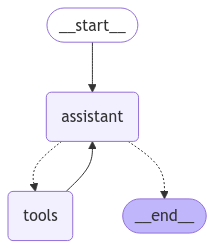

In [43]:
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

Invoke Graph

In [44]:
inputs = {"messages": [("human", "What are nodes in Langgraph?")]}

config = {
    "configurable":{
        "thread_id": str(uuid.uuid4()),
    }
}

async for chunk in react_graph.astream(inputs, stream_mode="values", config=config):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

What are nodes in Langgraph?
================================== Ai Message ==================================
Tool Calls:
  retrieve_documents (call_SGH6t5MxhO0GJHFuT8HnCXJn)
 Call ID: call_SGH6t5MxhO0GJHFuT8HnCXJn
  Args:
    query: nodes in Langgraph
================================= Tool Message =================================
Name: retrieve_documents

[Document(metadata={'id': '7a1fd835-9139-4ae9-810e-3a6aec16aecb', 'source': 'https://medium.com/cyberark-engineering/building-production-ready-ai-agents-with-langgraph-a-real-life-use-case-7bda34c7f4e4', 'title': 'Building Production-Ready AI Agents with LangGraph: A Real-Life Use Case | by Nir Bar | CyberArk Engineering | Medium', 'description': 'In my recent blog post, A Developer Guide for Creating a Multi-Modal Chatbot Using LangChain Agents, I discussed the role of AI Agents and demonstrated an implementation using the LangChain…', 'language': 'en

In [45]:
inputs = {"messages": [("human", "What is the weather in SF?")]}

config = {
    "configurable":{
        "thread_id": str(uuid.uuid4()),
    }
}

async for chunk in react_graph.astream(inputs, stream_mode="values", config=config):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

What is the weather in SF?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_DVDpAfEjCOvMnbTw9CsTuLD5)
 Call ID: call_DVDpAfEjCOvMnbTw9CsTuLD5
  Args:
    query: current weather in San Francisco
================================= Tool Message =================================
Name: web_search

[Document(metadata={'url': 'https://www.weatherapi.com/'}, page_content="{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.775, 'lon': -122.4183, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1738998752, 'localtime': '2025-02-07 23:12'}, 'current': {'last_updated_epoch': 1738998000, 'last_updated': '2025-02-07 23:00', 'temp_c': 8.9, 'temp_f': 48.0, 'is_day': 0, 'condition': {'text': 'Clear', 'icon': '//cdn.weatherapi.com/weather/64x64/night/113.png', 'code': 1000}, 'wind_mph': 6.0, 'wind_kp

In [48]:
inputs = {"messages": [("human", "Hi")]}

config = {
    "configurable":{
        "thread_id": str(uuid.uuid4()),
    }
}

async for chunk in react_graph.astream(inputs, stream_mode="values", config=config):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello! How can I assist you today?


In [47]:
inputs = {"messages": [("human", "Which one is the coolest place?")]}

config = {
    "configurable":{
        "thread_id": str(uuid.uuid4()),
    }
}

async for chunk in react_graph.astream(inputs, stream_mode="values", config=config):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Which one is the coolest place?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_dPWnROtJxVQVmyWcyaw39iIr)
 Call ID: call_dPWnROtJxVQVmyWcyaw39iIr
  Args:
    query: coolest places to visit in the world
================================= Tool Message =================================
Name: web_search

[Document(metadata={'url': 'https://www.forbes.com/sites/laurabegleybloom/2019/09/04/bucket-list-travel-the-top-50-places-in-the-world/'}, page_content='Bucket List Travel: The Top 50 Places In The World · 1. Bali, Indonesia: · 2. New Orleans: · 3. Kerry, Ireland: · 4. Marrakesh, Morocco: · 5. Sydney:'), Document(metadata={'url': 'https://travel.usnews.com/rankings/worlds-best-vacations/'}, page_content="World's Best Places to Visit for 2025 · Swiss Alps · Bora Bora · Rome · Machu Picchu · Tokyo · Maui · Maldives · Tanzania; Great Barrier Reef"), 